In [439]:
import pandas as  pd
import numpy  as  np
import matplotlib.pyplot  as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm_api
from sklearn import preprocessing
from scipy.stats import chi2_contingency

In [440]:
df  = pd.read_csv(r'/home/silva/Downloads/lista_empregados2.csv')

In [441]:
df_perfil = df

#Ajusta código empregado
df_perfil['COD_EMPREGADO'] = df_perfil['COD_EMPREGADO'].apply(str)
df_perfil['COD_EMPREGADO'] = 'B' + df_perfil['COD_EMPREGADO']

#Filtra colunas
df_perfil = df_perfil[['COD_EMPREGADO', 'DATA_ADMISSAO', 'DATA_NASCIMENTO', 'NIVEL_FUNCAO', 'EST_CIVIL', 'SEXO', 'DEP_CRECHE_BABA']]

#modifica tipo coluna
df_perfil['DATA_NASCIMENTO'] = df_perfil['DATA_NASCIMENTO'].apply(pd.to_datetime)
df_perfil['DATA_ADMISSAO'] = df_perfil['DATA_ADMISSAO'].apply(pd.to_datetime)

#Calcular tempo/idade
ano_hoje = pd.datetime.today().year
df_perfil['TEMPO_EMPRESA'] = ano_hoje -  df_perfil['DATA_ADMISSAO'].dt.year 
df_perfil['IDADE'] = ano_hoje - df_perfil['DATA_NASCIMENTO'].dt.year
df_perfil['COD_USUARIO'] = df_perfil['COD_EMPREGADO']

/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [442]:
#Cria classe
def cria_classe(valor, media, classe_abaixo, classe_acima):
    if valor > media:
        return classe_acima
    return classe_abaixo

#Boxplot
def plot_boxplot(df_class, df_features_standardized, w, h, classe):
    df_standardized = pd.concat([df_class,df_features_standardized],axis=1)
    df_melted = pd.melt(df_standardized,
                    id_vars=classe,
                    var_name="features",
                    value_name='value')
    plt.figure(figsize=(w,h))
    sns.boxplot(x="features", y="value", hue=classe, data=df_melted)
    
def binning(col, method='doane'):
    hist, bin_edges = np.histogram(col, method)
    bined_values = np.digitize(col, bin_edges)
    bin_interval = list()
    for x in range(0, len(bin_edges)):
        if x == 0:
            bin_interval.append('(-Inf,{0})'.format(bin_edges[x]))
        elif x == (len(bin_edges) - 1):
            # bin_interval.append('({0},Inf)'.format(bin_edges[x]))
            continue
        else:
            bin_interval.append('({0},{1})'.format(bin_edges[x], bin_edges[x+1]))

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=bin_edges, labels=bin_interval, include_lowest=True)

    return colBin


### Leitura dataset

In [443]:
df_cobertura = pd.read_csv(r'/home/silva/Downloads/tcc/cobertura_individual.csv')
df_cobertura['CSS'] = df_cobertura['CSS'].str.upper()
df_cobertura['NOME_CLASSE'] = df_cobertura['NOME_CLASSE'].str.upper()
df_cobertura['DATA'] = df_cobertura['ULT_ATUALIZACAO'].apply(pd.to_datetime)

#Remover sistemas não interessantes para o estudo
df_cobertura = df_cobertura[~df_cobertura['CSS'].str.startswith('PXC')]

#### Agrupamento dataset

In [444]:
#Seleciona ultima cobertura da classe
df_cobertura_ajustada = df_cobertura.sort_values('DATA').groupby(['NOME_CLASSE', 'COD_USUARIO']).tail(1)
#cria percentual coberto
df_cobertura_ajustada['PORCENTAGEM_COBERTA'] = 100 * df_cobertura_ajustada['LINHAS_COBERTAS'] / (df_cobertura_ajustada['LINHAS_NAO_COBERTAS'] + df_cobertura_ajustada['LINHAS_COBERTAS'])

#### Merge Datasets

In [445]:
df_final = pd.merge(df_cobertura_ajustada, df_perfil, on='COD_USUARIO', how='inner')

# Verificações

## Verificação cobertura por ocorrência

Text(0.5, 0.98, 'Porcentagem de cobertura de teste')

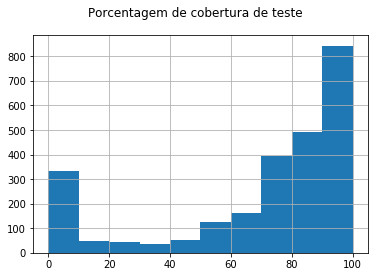

In [446]:
df_final['PORCENTAGEM_COBERTA'].hist()
plt.suptitle("Porcentagem de cobertura de teste")

## Filtro para remover cobertura abaixo de 20

mediana: 85.18518518518519
count    2534.000000
mean       69.797164
std        32.804781
min         0.000000
25%        58.887561
50%        81.496476
75%        94.444444
max       100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64


/home/silva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Porcentagem de teste')

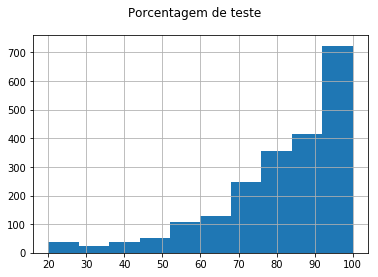

In [447]:
# Remove coberturas abaixo de 20%, pois de modo geral são classes apenas o construtor foi executado.
df_filtrada = df_final[df_final['PORCENTAGEM_COBERTA'] >= 20]
df_filtrada = df_filtrada[df_final['EST_CIVIL'] != 6]

#verifica
print("mediana: " + str(df_filtrada['PORCENTAGEM_COBERTA'].median()))
print(df_final['PORCENTAGEM_COBERTA'].describe())
df_filtrada['PORCENTAGEM_COBERTA'].hist()
plt.suptitle("Porcentagem de teste")

## Verifica usuários (únicos)

#### - Usuários únicos e total de ocorrências por usuário.

total de usuários únicos:155


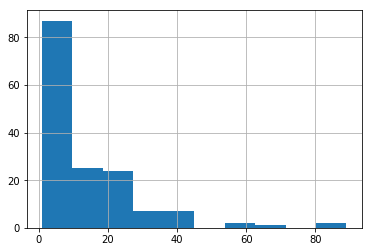

In [448]:
print("total de usuários únicos:" + str(len((df_filtrada['COD_USUARIO'].unique()))))
df_filtrada['COD_USUARIO'].value_counts().hist()

#### R: São diversos desenvolvedores, mas muitos possuem apenas 1 ocorrência de Cobertura de código testado.

### Verificações de idade de usuários 

Text(0.5, 0.98, 'Idade dos Desenvolvedores')

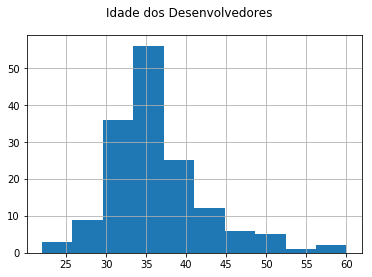

In [449]:
usuarios = df_filtrada.groupby('COD_USUARIO').tail(1)

#Verifica idade
usuarios['IDADE'].hist()
plt.suptitle("Idade dos Desenvolvedores")

### Verificações de tempo de empresa de usuários 

count    155.000000
mean       7.612903
std        4.360965
min        1.000000
25%        5.000000
50%        8.000000
75%       10.000000
max       31.000000
Name: TEMPO_EMPRESA, dtype: float64

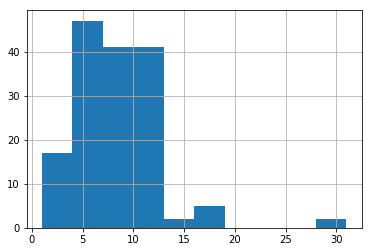

In [450]:
usuarios['TEMPO_EMPRESA'].hist()
usuarios['TEMPO_EMPRESA'].describe()

## Binning -> Porcentagem cobertura

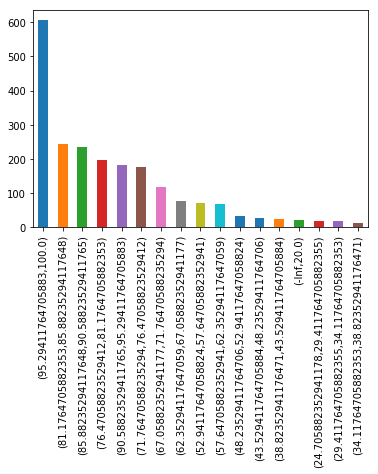

In [451]:
df_filtrada['BIN_PORCENTAGEM_COBERTA'] = binning(df_filtrada['PORCENTAGEM_COBERTA'])
df_filtrada['BIN_PORCENTAGEM_COBERTA'].value_counts().plot.bar()

In [452]:
df_filtrada['FAIXA_PORCENTAGEM_COBERTA'].value_counts()

KeyError: 'FAIXA_PORCENTAGEM_COBERTA'

### Categorização ESTADO CIVIL

In [453]:
def estado_civil(x):
    if x == 1:
        return "SOLTEIRO"
    elif x == 2:
        return "CASADO"
    else: return "DIVORCIADO"

df_filtrada['EST_CIVIL'] = df_filtrada['EST_CIVIL'].apply(lambda x : estado_civil(x))

In [454]:
df_filtrada['EST_CIVIL'] = df_filtrada['EST_CIVIL'].astype('category')

### Categorização -> Idade

In [455]:
def cria_classe_idade(x):
    if x < 30:
        return '20 anos'
    elif x >= 30 and x <= 40:
        return '30 anos'
    elif x > 40:
        return 'acima 40 anos'
    

df_filtrada['FAIXA_ETARIA'] = df_filtrada.apply(lambda x: cria_classe_idade(x['IDADE']), axis=1)
df_filtrada['FAIXA_ETARIA'] = df_filtrada[classe].astype('category')

### Binning idade

In [456]:
df_filtrada['BIN_IDADE'] = binning(df_filtrada['IDADE'])

### Categorização ERRO - ALERTA - OK
<br>A empresa considera: <br>-OK: acima de 80%<br>-ALERTA: entre 79% e 70%<br>-ERRO: abaixo de 70%

In [457]:
def ocorrencia(x):
    if x >= 80:
        return 'OK'
    elif x<80 and x>=70:
        return 'ALERTA'
    else: 
        return 'ERRO'

In [458]:
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada.apply(lambda x: ocorrencia(x['PORCENTAGEM_COBERTA']), axis=1)
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada['TIPO_OCORRENCIA'].astype('category')
df_filtrada['TIPO_OCORRENCIA'] = df_filtrada['TIPO_OCORRENCIA'].cat.reorder_categories(['OK', 'ALERTA', 'ERRO'])

In [459]:
#df_filtrada[df_filtrada['TIPO_OCORRENCIA'].cat.codes == 2].head()

### Salva para weka

In [460]:
guardar = df_filtrada[df_filtrada['TIPO_OCORRENCIA'] == 'ERRO']
guardar.to_csv(r'/home/silva/desenvolvedor/export_dataframe.csv', index = None, header=True)

# Verificação do DATASET tratado

### Verificação dos registros de cobertura de código de teste

### V1) Distribuição de idade dos desenvolvedores que gravaram registros

In [461]:
print("Tamanho amostra: {0}".format(len(df_filtrada)))

Tamanho amostra: 2123


Text(0.5, 0.98, 'Idade dos Desenvolvedores nas amostras')

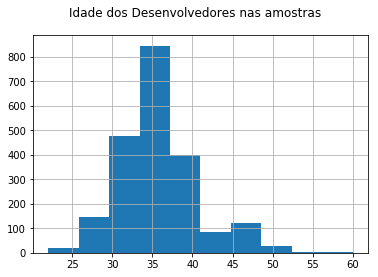

In [462]:
df_filtrada['IDADE'].hist()
plt.suptitle("Idade dos Desenvolvedores nas amostras")

In [463]:
print("mediana:" + str(df_filtrada['IDADE'].median()))
df_filtrada['IDADE'].describe()

mediana:35.0


count    2123.000000
mean       35.787565
std         5.000527
min        22.000000
25%        33.000000
50%        35.000000
75%        38.000000
max        60.000000
Name: IDADE, dtype: float64

### V2) Tempo de empresa dos desenvolvedores que gravaram registros

Text(0.5, 0.98, 'Tempo de empresa relativo aos registros gravados')

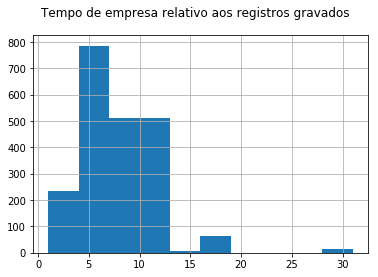

In [464]:
df_filtrada['TEMPO_EMPRESA'].hist()
plt.suptitle("Tempo de empresa relativo aos registros gravados")

In [465]:
print("mediana:" + str(df_filtrada['TEMPO_EMPRESA'].median()))
df_filtrada['TEMPO_EMPRESA'].describe()

mediana:8.0


count    2123.000000
mean        7.178050
std         3.841873
min         1.000000
25%         5.000000
50%         8.000000
75%        10.000000
max        31.000000
Name: TEMPO_EMPRESA, dtype: float64

### V3) Faixa etária desenvolvedor

30 anos          1718
acima 40 anos     240
20 anos           165
Name: FAIXA_ETARIA, dtype: int64


Text(0.5, 0.98, 'Faixa etária desenvolvedor que gerou ocorrência')

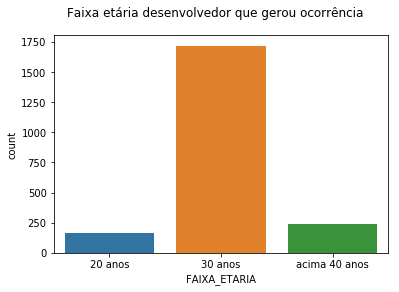

In [466]:
print(df_filtrada[classe].value_counts())
sns.countplot(df_filtrada[classe],label="Count")
plt.suptitle("Faixa etária desenvolvedor que gerou ocorrência")

In [467]:
df_20 = df_filtrada[df_filtrada[classe] == '20 anos']
df_30 = df_filtrada[df_filtrada[classe] == '30 anos']
df_40 = df_filtrada[df_filtrada[classe] == 'acima 40 anos']

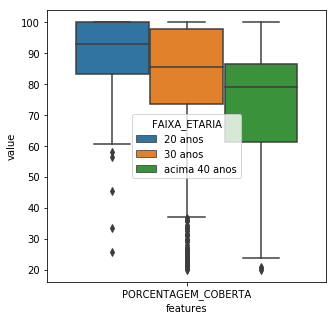

In [468]:
plot_boxplot(df_filtrada[classe], df_filtrada['PORCENTAGEM_COBERTA'], 5, 5, classe)

### T) Teste de distribuições

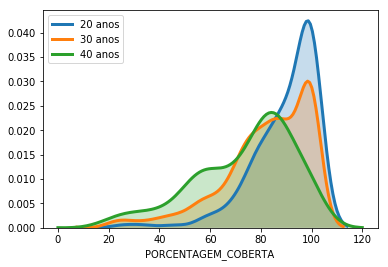

In [469]:
sns.distplot(df_20['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '20 anos')
sns.distplot(df_30['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '30 anos')
sns.distplot(df_40['PORCENTAGEM_COBERTA'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3},  label = '40 anos')

In [470]:
print('median:' + str(df_20['PORCENTAGEM_COBERTA'].median()))
print(df_20['PORCENTAGEM_COBERTA'].describe())
print('----------------------')
print('median:' + str(df_30['PORCENTAGEM_COBERTA'].median()))
print(df_30['PORCENTAGEM_COBERTA'].describe())
print('----------------------')
print('median:' + str(df_40['PORCENTAGEM_COBERTA'].median()))
print(df_40['PORCENTAGEM_COBERTA'].describe())

median:93.02325581395348
count    165.000000
mean      89.519182
std       12.990635
min       25.523013
25%       83.467742
50%       93.023256
75%      100.000000
max      100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64
----------------------
median:85.41666666666667
count    1718.000000
mean       82.151822
std        17.388145
min        20.000000
25%        73.460478
50%        85.416667
75%        97.843619
max       100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64
----------------------
median:78.99574303405572
count    240.000000
mean      73.718148
std       19.355238
min       20.000000
25%       61.310393
50%       78.995743
75%       86.659607
max      100.000000
Name: PORCENTAGEM_COBERTA, dtype: float64


### T1)Verificação da existência de diferença nas distribuições, usando toda distribuição e ocorrências

In [471]:
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_30['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_30['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_20['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_30['PORCENTAGEM_COBERTA'], df_40['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=88.29236422112848, pvalue=6.722900942903351e-20)
KruskalResult(statistic=32.41167259623873, pvalue=1.2473497559800273e-08)
KruskalResult(statistic=84.17282872786805, pvalue=4.53358719540117e-20)
KruskalResult(statistic=47.06856027076317, pvalue=6.854645976955679e-12)


#### RT1) Pelo teste de Kruskal wallis, rejeita-se a hipótese nula, pois há indícioes que a média das distribuições são diferentes, levando em conta a faixa etaria 

### T2)Verificação de diferença nas distribuições, separando por faixa etária e sexo

In [472]:
print(stats.kruskal(df_20[df_20['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_20[df_20['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_30[df_30['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_30[df_30['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_40[df_40['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='F']['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=0.09776500328051212, pvalue=0.7545283836044219)
KruskalResult(statistic=7.237025988898016, pvalue=0.0071415176471908235)
KruskalResult(statistic=0.42063490403141873, pvalue=0.5166204094200435)


#### RT2: Existe diferença significativa apenas na faixa etária de 30 anos, entre os sexos

### T3)Verificação de diferença nas distribuições entre faixa etária (dividido por sexo)

In [473]:
print('Masculino: 20 anos <-> 30 anos')
print(stats.kruskal(df_20[df_20['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_30[df_30['SEXO']=='M']['PORCENTAGEM_COBERTA']))
print('Masculino: 20 anos <-> 40 anos')
print(stats.kruskal(df_20[df_20['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='M']['PORCENTAGEM_COBERTA']))
print('Masculino: 30 anos <-> 40 anos')
print(stats.kruskal(df_30[df_30['SEXO']=='M']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='M']['PORCENTAGEM_COBERTA']))

Masculino: 20 anos <-> 30 anos
KruskalResult(statistic=33.72860864183158, pvalue=6.336196796192806e-09)
Masculino: 20 anos <-> 40 anos
KruskalResult(statistic=81.90997722993666, pvalue=1.424284830997749e-19)
Masculino: 30 anos <-> 40 anos
KruskalResult(statistic=42.67074598493471, pvalue=6.477378897842572e-11)


#### RT3.1: Olhando apenas a população masculina, existe diferença significativa em todas as faixas etárias

In [474]:
print(stats.kruskal(df_20[df_20['SEXO']=='F']['PORCENTAGEM_COBERTA'], df_30[df_30['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_20[df_20['SEXO']=='F']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='F']['PORCENTAGEM_COBERTA']))
print(stats.kruskal(df_30[df_30['SEXO']=='F']['PORCENTAGEM_COBERTA'], df_40[df_40['SEXO']=='F']['PORCENTAGEM_COBERTA']))

KruskalResult(statistic=0.11185715620916344, pvalue=0.738039615870417)
KruskalResult(statistic=3.147482014388489, pvalue=0.07604422422008318)
KruskalResult(statistic=2.3184464203742117, pvalue=0.12784765808273382)


#### RT3.2: Não existem diferenças significativa entre as faixas etárias, dentro do sexo feminino

### T4)Verificação da existência de diferença nas distribuições, usando apenas erros

In [475]:
df_20_erro_masculino = df_20[(df_20['SEXO']=='M') & (df_20['TIPO_OCORRENCIA']=='ERRO')]['PORCENTAGEM_COBERTA']
df_30_erro_masculino = df_30[(df_30['SEXO']=='M') & (df_30['TIPO_OCORRENCIA']=='ERRO')]['PORCENTAGEM_COBERTA']
df_40_erro_masculino = df_40[(df_40['SEXO']=='M') & (df_40['TIPO_OCORRENCIA']=='ERRO')]['PORCENTAGEM_COBERTA']
df_20_erro_feminino = df_20[(df_20['SEXO']=='F') & (df_20['TIPO_OCORRENCIA']=='ERRO')]['PORCENTAGEM_COBERTA']
df_30_erro_feminino = df_30[(df_30['SEXO']=='F') & (df_30['TIPO_OCORRENCIA']=='ERRO')]['PORCENTAGEM_COBERTA']
df_40_erro_feminino = df_40[(df_40['SEXO']=='F') & (df_40['TIPO_OCORRENCIA']=='ERRO')]['PORCENTAGEM_COBERTA']

print(stats.kruskal(df_20_erro_masculino, df_20_erro_feminino))
print(stats.kruskal(df_30_erro_masculino, df_30_erro_feminino))
print(stats.kruskal(df_40_erro_masculino, df_30_erro_feminino))

KruskalResult(statistic=nan, pvalue=nan)
KruskalResult(statistic=8.298293677787013, pvalue=0.00396823448935263)
KruskalResult(statistic=13.442129430265789, pvalue=0.0002460361958385722)


In [476]:
### R4

In [477]:
print(stats.kruskal(df_40_erro_masculino, df_30_erro_feminino))

KruskalResult(statistic=13.442129430265789, pvalue=0.0002460361958385722)


## A Priori

EST_CIVIL - SEXO - FAIXA_ETARIA - TIPO_OCORRENCIA

# === Run information ===

Scheme:       weka.associations.Apriori -I -N 100 -T 0 -C 0.6 -D 0.05 -U 1.0 -M 0.1 -S -1.0 -c -1
Relation:     export_dataframe-weka.filters.unsupervised.attribute.Remove-R1-12,15-18,20
Instances:    417
Attributes:   4
              EST_CIVIL
              SEXO
              FAIXA_ETARIA
              TIPO_OCORRENCIA
=== Associator model (full training set) ===


Apriori
=======

Minimum support: 0.1 (42 instances)
Minimum metric <confidence>: 0.6
Number of cycles performed: 18

Generated sets of large itemsets:

Size of set of large itemsets L(1): 6

Large Itemsets L(1):
EST_CIVIL=CASADO 97
EST_CIVIL=SOLTEIRO 320
SEXO=M 400
FAIXA_ETARIA=acima 40 anos 83
FAIXA_ETARIA=30 anos 324
TIPO_OCORRENCIA=ERRO 417

Size of set of large itemsets L(2): 12

Large Itemsets L(2):
EST_CIVIL=CASADO SEXO=M 97
EST_CIVIL=CASADO FAIXA_ETARIA=30 anos 79
EST_CIVIL=CASADO TIPO_OCORRENCIA=ERRO 97
EST_CIVIL=SOLTEIRO SEXO=M 303
EST_CIVIL=SOLTEIRO FAIXA_ETARIA=acima 40 anos 66
EST_CIVIL=SOLTEIRO FAIXA_ETARIA=30 anos 245
EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 320
SEXO=M FAIXA_ETARIA=acima 40 anos 83
SEXO=M FAIXA_ETARIA=30 anos 307
SEXO=M TIPO_OCORRENCIA=ERRO 400
FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 83
FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 324

Size of set of large itemsets L(3): 10

Large Itemsets L(3):
EST_CIVIL=CASADO SEXO=M FAIXA_ETARIA=30 anos 79
EST_CIVIL=CASADO SEXO=M TIPO_OCORRENCIA=ERRO 97
EST_CIVIL=CASADO FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 79
EST_CIVIL=SOLTEIRO SEXO=M FAIXA_ETARIA=acima 40 anos 66
EST_CIVIL=SOLTEIRO SEXO=M FAIXA_ETARIA=30 anos 228
EST_CIVIL=SOLTEIRO SEXO=M TIPO_OCORRENCIA=ERRO 303
EST_CIVIL=SOLTEIRO FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 66
EST_CIVIL=SOLTEIRO FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 245
SEXO=M FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 83
SEXO=M FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 307

Size of set of large itemsets L(4): 3

Large Itemsets L(4):
EST_CIVIL=CASADO SEXO=M FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 79
EST_CIVIL=SOLTEIRO SEXO=M FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 66
EST_CIVIL=SOLTEIRO SEXO=M FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 228

Best rules found:

  1. SEXO=M 400 ==> TIPO_OCORRENCIA=ERRO 400    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  2. FAIXA_ETARIA=30 anos 324 ==> TIPO_OCORRENCIA=ERRO 324    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  3. EST_CIVIL=SOLTEIRO 320 ==> TIPO_OCORRENCIA=ERRO 320    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  4. SEXO=M FAIXA_ETARIA=30 anos 307 ==> TIPO_OCORRENCIA=ERRO 307    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  5. EST_CIVIL=SOLTEIRO SEXO=M 303 ==> TIPO_OCORRENCIA=ERRO 303    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  6. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=30 anos 245 ==> TIPO_OCORRENCIA=ERRO 245    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  7. EST_CIVIL=SOLTEIRO SEXO=M FAIXA_ETARIA=30 anos 228 ==> TIPO_OCORRENCIA=ERRO 228    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
  8. EST_CIVIL=CASADO 97 ==> SEXO=M 97    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.95)
  9. EST_CIVIL=CASADO 97 ==> TIPO_OCORRENCIA=ERRO 97    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 10. EST_CIVIL=CASADO TIPO_OCORRENCIA=ERRO 97 ==> SEXO=M 97    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.95)
 11. EST_CIVIL=CASADO SEXO=M 97 ==> TIPO_OCORRENCIA=ERRO 97    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 12. EST_CIVIL=CASADO 97 ==> SEXO=M TIPO_OCORRENCIA=ERRO 97    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.95)
 13. FAIXA_ETARIA=acima 40 anos 83 ==> SEXO=M 83    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.38)
 14. FAIXA_ETARIA=acima 40 anos 83 ==> TIPO_OCORRENCIA=ERRO 83    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 15. FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 83 ==> SEXO=M 83    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.38)
 16. SEXO=M FAIXA_ETARIA=acima 40 anos 83 ==> TIPO_OCORRENCIA=ERRO 83    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 17. FAIXA_ETARIA=acima 40 anos 83 ==> SEXO=M TIPO_OCORRENCIA=ERRO 83    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.38)
 18. EST_CIVIL=CASADO FAIXA_ETARIA=30 anos 79 ==> SEXO=M 79    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.22)
 19. EST_CIVIL=CASADO FAIXA_ETARIA=30 anos 79 ==> TIPO_OCORRENCIA=ERRO 79    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 20. EST_CIVIL=CASADO FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 79 ==> SEXO=M 79    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.22)
 21. EST_CIVIL=CASADO SEXO=M FAIXA_ETARIA=30 anos 79 ==> TIPO_OCORRENCIA=ERRO 79    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 22. EST_CIVIL=CASADO FAIXA_ETARIA=30 anos 79 ==> SEXO=M TIPO_OCORRENCIA=ERRO 79    <conf:(1)> lift:(1.04) lev:(0.01) [3] conv:(3.22)
 23. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=acima 40 anos 66 ==> SEXO=M 66    <conf:(1)> lift:(1.04) lev:(0.01) [2] conv:(2.69)
 24. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=acima 40 anos 66 ==> TIPO_OCORRENCIA=ERRO 66    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 25. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 66 ==> SEXO=M 66    <conf:(1)> lift:(1.04) lev:(0.01) [2] conv:(2.69)
 26. EST_CIVIL=SOLTEIRO SEXO=M FAIXA_ETARIA=acima 40 anos 66 ==> TIPO_OCORRENCIA=ERRO 66    <conf:(1)> lift:(1) lev:(0) [0] conv:(0)
 27. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=acima 40 anos 66 ==> SEXO=M TIPO_OCORRENCIA=ERRO 66    <conf:(1)> lift:(1.04) lev:(0.01) [2] conv:(2.69)
 28. TIPO_OCORRENCIA=ERRO 417 ==> SEXO=M 400    <conf:(0.96)> lift:(1) lev:(0) [0] conv:(0.94)
 29. FAIXA_ETARIA=30 anos 324 ==> SEXO=M 307    <conf:(0.95)> lift:(0.99) lev:(-0.01) [-3] conv:(0.73)
 30. FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 324 ==> SEXO=M 307    <conf:(0.95)> lift:(0.99) lev:(-0.01) [-3] conv:(0.73)
 31. FAIXA_ETARIA=30 anos 324 ==> SEXO=M TIPO_OCORRENCIA=ERRO 307    <conf:(0.95)> lift:(0.99) lev:(-0.01) [-3] conv:(0.73)
 32. EST_CIVIL=SOLTEIRO 320 ==> SEXO=M 303    <conf:(0.95)> lift:(0.99) lev:(-0.01) [-3] conv:(0.72)
 33. EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 320 ==> SEXO=M 303    <conf:(0.95)> lift:(0.99) lev:(-0.01) [-3] conv:(0.72)
 34. EST_CIVIL=SOLTEIRO 320 ==> SEXO=M TIPO_OCORRENCIA=ERRO 303    <conf:(0.95)> lift:(0.99) lev:(-0.01) [-3] conv:(0.72)
 35. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=30 anos 245 ==> SEXO=M 228    <conf:(0.93)> lift:(0.97) lev:(-0.02) [-7] conv:(0.55)
 36. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 245 ==> SEXO=M 228    <conf:(0.93)> lift:(0.97) lev:(-0.02) [-7] conv:(0.55)
 37. EST_CIVIL=SOLTEIRO FAIXA_ETARIA=30 anos 245 ==> SEXO=M TIPO_OCORRENCIA=ERRO 228    <conf:(0.93)> lift:(0.97) lev:(-0.02) [-7] conv:(0.55)
 38. EST_CIVIL=CASADO 97 ==> FAIXA_ETARIA=30 anos 79    <conf:(0.81)> lift:(1.05) lev:(0.01) [3] conv:(1.14)
 39. EST_CIVIL=CASADO SEXO=M 97 ==> FAIXA_ETARIA=30 anos 79    <conf:(0.81)> lift:(1.05) lev:(0.01) [3] conv:(1.14)
 40. EST_CIVIL=CASADO 97 ==> SEXO=M FAIXA_ETARIA=30 anos 79    <conf:(0.81)> lift:(1.11) lev:(0.02) [7] conv:(1.35)
 41. EST_CIVIL=CASADO TIPO_OCORRENCIA=ERRO 97 ==> FAIXA_ETARIA=30 anos 79    <conf:(0.81)> lift:(1.05) lev:(0.01) [3] conv:(1.14)
 42. EST_CIVIL=CASADO 97 ==> FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 79    <conf:(0.81)> lift:(1.05) lev:(0.01) [3] conv:(1.14)
 43. EST_CIVIL=CASADO SEXO=M TIPO_OCORRENCIA=ERRO 97 ==> FAIXA_ETARIA=30 anos 79    <conf:(0.81)> lift:(1.05) lev:(0.01) [3] conv:(1.14)
 44. EST_CIVIL=CASADO TIPO_OCORRENCIA=ERRO 97 ==> SEXO=M FAIXA_ETARIA=30 anos 79    <conf:(0.81)> lift:(1.11) lev:(0.02) [7] conv:(1.35)
 45. EST_CIVIL=CASADO SEXO=M 97 ==> FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 79    <conf:(0.81)> lift:(1.05) lev:(0.01) [3] conv:(1.14)
 46. EST_CIVIL=CASADO 97 ==> SEXO=M FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 79    <conf:(0.81)> lift:(1.11) lev:(0.02) [7] conv:(1.35)
 47. FAIXA_ETARIA=acima 40 anos 83 ==> EST_CIVIL=SOLTEIRO 66    <conf:(0.8)> lift:(1.04) lev:(0.01) [2] conv:(1.07)
 48. SEXO=M FAIXA_ETARIA=acima 40 anos 83 ==> EST_CIVIL=SOLTEIRO 66    <conf:(0.8)> lift:(1.04) lev:(0.01) [2] conv:(1.07)
 49. FAIXA_ETARIA=acima 40 anos 83 ==> EST_CIVIL=SOLTEIRO SEXO=M 66    <conf:(0.8)> lift:(1.09) lev:(0.01) [5] conv:(1.26)
 50. FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 83 ==> EST_CIVIL=SOLTEIRO 66    <conf:(0.8)> lift:(1.04) lev:(0.01) [2] conv:(1.07)
 51. FAIXA_ETARIA=acima 40 anos 83 ==> EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 66    <conf:(0.8)> lift:(1.04) lev:(0.01) [2] conv:(1.07)
 52. SEXO=M FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 83 ==> EST_CIVIL=SOLTEIRO 66    <conf:(0.8)> lift:(1.04) lev:(0.01) [2] conv:(1.07)
 53. FAIXA_ETARIA=acima 40 anos TIPO_OCORRENCIA=ERRO 83 ==> EST_CIVIL=SOLTEIRO SEXO=M 66    <conf:(0.8)> lift:(1.09) lev:(0.01) [5] conv:(1.26)
 54. SEXO=M FAIXA_ETARIA=acima 40 anos 83 ==> EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 66    <conf:(0.8)> lift:(1.04) lev:(0.01) [2] conv:(1.07)
 55. FAIXA_ETARIA=acima 40 anos 83 ==> EST_CIVIL=SOLTEIRO SEXO=M TIPO_OCORRENCIA=ERRO 66    <conf:(0.8)> lift:(1.09) lev:(0.01) [5] conv:(1.26)
 56. TIPO_OCORRENCIA=ERRO 417 ==> FAIXA_ETARIA=30 anos 324    <conf:(0.78)> lift:(1) lev:(0) [0] conv:(0.99)
 57. SEXO=M 400 ==> FAIXA_ETARIA=30 anos 307    <conf:(0.77)> lift:(0.99) lev:(-0.01) [-3] conv:(0.95)
 58. SEXO=M TIPO_OCORRENCIA=ERRO 400 ==> FAIXA_ETARIA=30 anos 307    <conf:(0.77)> lift:(0.99) lev:(-0.01) [-3] conv:(0.95)
 59. SEXO=M 400 ==> FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 307    <conf:(0.77)> lift:(0.99) lev:(-0.01) [-3] conv:(0.95)
 60. TIPO_OCORRENCIA=ERRO 417 ==> EST_CIVIL=SOLTEIRO 320    <conf:(0.77)> lift:(1) lev:(0) [0] conv:(0.99)
 61. EST_CIVIL=SOLTEIRO 320 ==> FAIXA_ETARIA=30 anos 245    <conf:(0.77)> lift:(0.99) lev:(-0.01) [-3] conv:(0.94)
 62. EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 320 ==> FAIXA_ETARIA=30 anos 245    <conf:(0.77)> lift:(0.99) lev:(-0.01) [-3] conv:(0.94)
 63. EST_CIVIL=SOLTEIRO 320 ==> FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 245    <conf:(0.77)> lift:(0.99) lev:(-0.01) [-3] conv:(0.94)
 64. SEXO=M 400 ==> EST_CIVIL=SOLTEIRO 303    <conf:(0.76)> lift:(0.99) lev:(-0.01) [-3] conv:(0.95)
 65. SEXO=M TIPO_OCORRENCIA=ERRO 400 ==> EST_CIVIL=SOLTEIRO 303    <conf:(0.76)> lift:(0.99) lev:(-0.01) [-3] conv:(0.95)
 66. SEXO=M 400 ==> EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 303    <conf:(0.76)> lift:(0.99) lev:(-0.01) [-3] conv:(0.95)
 67. FAIXA_ETARIA=30 anos 324 ==> EST_CIVIL=SOLTEIRO 245    <conf:(0.76)> lift:(0.99) lev:(-0.01) [-3] conv:(0.94)
 68. FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 324 ==> EST_CIVIL=SOLTEIRO 245    <conf:(0.76)> lift:(0.99) lev:(-0.01) [-3] conv:(0.94)
 69. FAIXA_ETARIA=30 anos 324 ==> EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 245    <conf:(0.76)> lift:(0.99) lev:(-0.01) [-3] conv:(0.94)
 70. EST_CIVIL=SOLTEIRO SEXO=M 303 ==> FAIXA_ETARIA=30 anos 228    <conf:(0.75)> lift:(0.97) lev:(-0.02) [-7] conv:(0.89)
 71. EST_CIVIL=SOLTEIRO SEXO=M TIPO_OCORRENCIA=ERRO 303 ==> FAIXA_ETARIA=30 anos 228    <conf:(0.75)> lift:(0.97) lev:(-0.02) [-7] conv:(0.89)
 72. EST_CIVIL=SOLTEIRO SEXO=M 303 ==> FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 228    <conf:(0.75)> lift:(0.97) lev:(-0.02) [-7] conv:(0.89)
 73. SEXO=M FAIXA_ETARIA=30 anos 307 ==> EST_CIVIL=SOLTEIRO 228    <conf:(0.74)> lift:(0.97) lev:(-0.02) [-7] conv:(0.89)
 74. SEXO=M FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 307 ==> EST_CIVIL=SOLTEIRO 228    <conf:(0.74)> lift:(0.97) lev:(-0.02) [-7] conv:(0.89)
 75. SEXO=M FAIXA_ETARIA=30 anos 307 ==> EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 228    <conf:(0.74)> lift:(0.97) lev:(-0.02) [-7] conv:(0.89)
 76. TIPO_OCORRENCIA=ERRO 417 ==> SEXO=M FAIXA_ETARIA=30 anos 307    <conf:(0.74)> lift:(1) lev:(0) [0] conv:(0.99)
 77. TIPO_OCORRENCIA=ERRO 417 ==> EST_CIVIL=SOLTEIRO SEXO=M 303    <conf:(0.73)> lift:(1) lev:(0) [0] conv:(0.99)
 78. EST_CIVIL=SOLTEIRO 320 ==> SEXO=M FAIXA_ETARIA=30 anos 228    <conf:(0.71)> lift:(0.97) lev:(-0.02) [-7] conv:(0.91)
 79. EST_CIVIL=SOLTEIRO TIPO_OCORRENCIA=ERRO 320 ==> SEXO=M FAIXA_ETARIA=30 anos 228    <conf:(0.71)> lift:(0.97) lev:(-0.02) [-7] conv:(0.91)
 80. EST_CIVIL=SOLTEIRO 320 ==> SEXO=M FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 228    <conf:(0.71)> lift:(0.97) lev:(-0.02) [-7] conv:(0.91)
 81. FAIXA_ETARIA=30 anos 324 ==> EST_CIVIL=SOLTEIRO SEXO=M 228    <conf:(0.7)> lift:(0.97) lev:(-0.02) [-7] conv:(0.91)
 82. FAIXA_ETARIA=30 anos TIPO_OCORRENCIA=ERRO 324 ==> EST_CIVIL=SOLTEIRO SEXO=M 228    <conf:(0.7)> lift:(0.97) lev:(-0.02) [-7] conv:(0.91)
 83. FAIXA_ETARIA=30 anos 324 ==> EST_CIVIL=SOLTEIRO SEXO=M TIPO_OCORRENCIA=ERRO 228    <conf:(0.7)> lift:(0.97) lev:(-0.02) [-7] conv:(0.91)


## A Priori-2

## Verificações Qui-quadrado

### Q1- Faixa etária - Sexo - Estado civil = Ocorrencia Erro | Alerta

In [303]:
def unstack_group(df, y, group):
    group.append(y)
    groupsizes = df.groupby(group).size()
    ctsum = groupsizes.unstack(y)
    return ctsum.fillna(0)

In [379]:
df1 = unstack_group(df_filtrada, 'TIPO_OCORRENCIA', ['FAIXA_ETARIA', 'SEXO', 'EST_CIVIL'])
#df1 = df1.loc[['ERRO', 'ALERTA']]
df1[['ALERTA', 'ERRO']]

TIPO_OCORRENCIA               ALERTA   ERRO
FAIXA_ETARIA  SEXO EST_CIVIL               
20 anos       F    SOLTEIRO      1.0    0.0
              M    CASADO        9.0    1.0
                   SOLTEIRO     13.0    9.0
30 anos       F    SOLTEIRO     19.0   17.0
              M    CASADO       71.0   79.0
                   SOLTEIRO    235.0  228.0
acima 40 anos F    SOLTEIRO      6.0    0.0
              M    CASADO       12.0   17.0
                   SOLTEIRO     22.0   66.0

In [380]:
chi2_contingency(df1[['ALERTA', 'ERRO']])

(36.635776030304065,
 1.3426624389807962e-05,
 8,
 array([[  0.48198758,   0.51801242],
        [  4.81987578,   5.18012422],
        [ 10.60372671,  11.39627329],
        [ 17.3515528 ,  18.6484472 ],
        [ 72.29813665,  77.70186335],
        [223.16024845, 239.83975155],
        [  2.89192547,   3.10807453],
        [ 13.97763975,  15.02236025],
        [ 42.41490683,  45.58509317]]))

#### R1: Há indícios de das variáveis serem dependentes.

### Q2- Faixa etária - Sexo - Estado civil = Ocorrencia Erro | Alerta

In [377]:
df1 = unstack_group(df_filtrada, 'FAIXA_ETARIA', ['TIPO_OCORRENCIA', 'SEXO', 'EST_CIVIL'])
df1 = df1.loc[['ERRO', 'ALERTA']]
df1

FAIXA_ETARIA                    20 anos  30 anos  acima 40 anos
TIPO_OCORRENCIA SEXO EST_CIVIL                                 
ALERTA          F    SOLTEIRO       1.0     19.0            6.0
                M    CASADO         9.0     71.0           12.0
                     SOLTEIRO      13.0    235.0           22.0
ERRO            F    SOLTEIRO       0.0     17.0            0.0
                M    CASADO         1.0     79.0           17.0
                     SOLTEIRO       9.0    228.0           66.0

In [357]:
chi2_contingency(df2)

(7.2712636125120405,
 0.12222895600068359,
 4,
 array([[  0.40767386,  13.20863309,   3.38369305],
        [  2.32613909,  75.36690647,  19.30695444],
        [  7.26618705, 235.42446043,  60.30935252]]))

In [373]:
df3 = unstack_group(df_filtrada, 'SEXO', ['TIPO_OCORRENCIA'])

a = df3[['M', 'F']]

In [374]:
chi2_contingency(a)

(6.4490649629096986,
 0.03977437248684426,
 2,
 array([[1228.60197833,   89.39802167],
        [ 361.68252473,   26.31747527],
        [ 388.71549694,   28.28450306]]))

In [301]:
df2 = unstack_group(df_filtrada, 'SEXO', ['TIPO_OCORRENCIA'])
df2

SEXO,F,M
TIPO_OCORRENCIA,,
OK,101,1217
ALERTA,26,362
ERRO,17,400


In [302]:
chi2_contingency(df2)

(6.449064962909699,
 0.039774372486844255,
 2,
 array([[  89.39802167, 1228.60197833],
        [  26.31747527,  361.68252473],
        [  28.28450306,  388.71549694]]))